# This file computes diagonalisation & pre-computes results for use later

## Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import save, savez, savez_compressed
import ast

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

from matplotlib.pyplot import spy

import scipy.constants

## Defining parameters

In [3]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
MOLECULE["a0"] = Rb87Cs133["a0"]
MOLECULE["a2"] = Rb87Cs133["a2"]
N_MAX = 1

B = 35 * 1e-4 # T
I = 129 #W/m^2
r = 0.5 * 1e-6 # m

H_BAR = scipy.constants.hbar

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*MOLECULE["I1"])
I2_D = round(2*MOLECULE["I2"])
D_0 = MOLECULE["d0"]

PER_MN = (I1_D+1)*(I2_D+1)
N_STATES = PER_MN * (N_MAX+1)**2

In [55]:
print(MOLECULE["MuN"]/scipy.constants.physical_constants['nuclear magneton'][0])

0.001


## Diagonalise & Calculate 

In [56]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, MOLECULE, zeeman=True, Edc=False, ac=True)

H = (
    +H0[...]
    +Hz[...]*B
    +Hac[...]*I
    )

In [57]:
H_PAIR = np.kron(H,H)

In [58]:
# ENERGIES, STATES = eigh(H)

In [59]:
dipole_op_zero = calculate.dipole(N_MAX,I1,I2,1,0)
dipole_op_minus = calculate.dipole(N_MAX,I1,I2,1,-1)
dipole_op_plus = calculate.dipole(N_MAX,I1,I2,1,+1)

# Form Tensor Prod'd Matrices

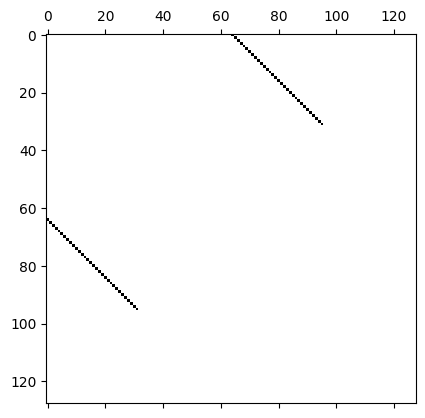

In [45]:
# PROD_STATES = np.kron(STATES,STATES)
spy(dipole_op_zero)

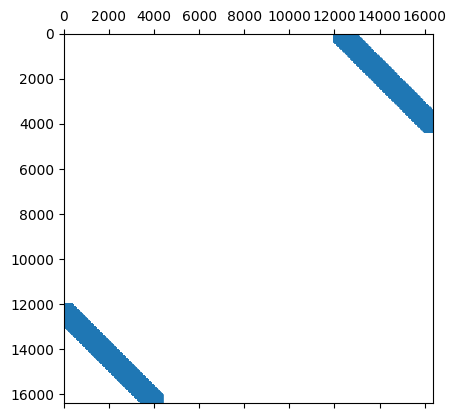

In [53]:
# PROD_STATES.shape
spy(dipdjm,markersize=10)

In [60]:
# Tensor product hell time
di0dj0 = np.kron(dipole_op_zero, dipole_op_zero)
dipdjm = np.kron(dipole_op_plus, dipole_op_minus)
dimdjp = np.kron(dipole_op_minus, dipole_op_plus)
dipdjp = np.kron(dipole_op_plus, dipole_op_plus)
dimdjm = np.kron(dipole_op_minus, dipole_op_minus)

In [71]:
V_dd = (D_0**2/(4*np.pi*scipy.constants.epsilon_0*r**3)) * ((di0dj0+(dipdjm+dimdjp)/2)-3*(dipdjp+dimdjm))

(8258.646159155427+0j)


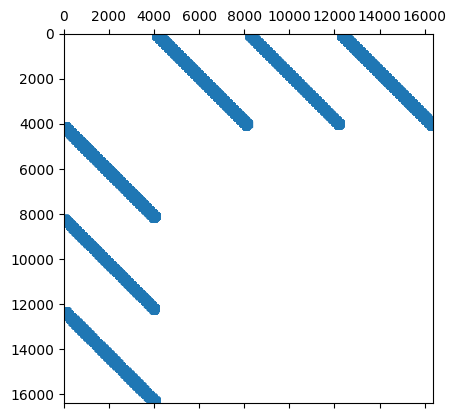

In [72]:
spy(V_dd,markersize=5)
print(np.max(V_dd)/scipy.constants.h)

In [12]:
# H_dd = PROD_STATES.conj().T @ V_dd @ PROD_STATES

In [73]:
H_tot = V_dd + H_PAIR

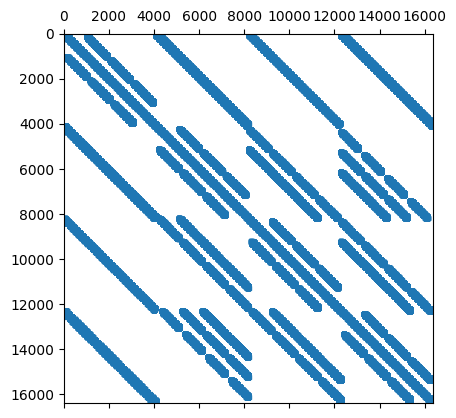

In [69]:
# ENERGIES_PAIR, STATES_PAIR = eigh(H_tot)
spy(H_tot, markersize=3)

In [66]:
N_PAIR_STATES = (32+96)**2
print(N_PAIR_STATES)
UNCOUPLED_LABELS_D = []

for n in range(0, N_MAX + 1):
    for mn in range(n,-(n+1),-1):
        for mi1d in range(I1_D,-I1_D-1,-2):
            for mi2d in range(I2_D,-I2_D-1,-2):
                for nprime in range(0, N_MAX+ 1):
                    for mnp in range(nprime,-(nprime+1),-1):
                        for mi1dp in range(I1_D,-I1_D-1,-2):
                            for mi2dp in range(I2_D,-I2_D-1,-2):
                                UNCOUPLED_LABELS_D.append((n,mn,mi1d,mi2d,nprime,mnp,mi1dp,mi2dp))

UNCOUPLED_LABELS_D = (np.rint(UNCOUPLED_LABELS_D)).astype("int")

16384


In [67]:
state_index_a = np.where((UNCOUPLED_LABELS_D[:, 0] == 0) 
               & (UNCOUPLED_LABELS_D[:, 1] == 0)
               & (UNCOUPLED_LABELS_D[:, 2] == 3)
               & (UNCOUPLED_LABELS_D[:, 3] == 7)
               & (UNCOUPLED_LABELS_D[:, 4] == 1)
               & (UNCOUPLED_LABELS_D[:, 5] == -1)
               & (UNCOUPLED_LABELS_D[:, 6] == 3)
               & (UNCOUPLED_LABELS_D[:, 7] == 7))[0][0]
state_index_b = np.where((UNCOUPLED_LABELS_D[:, 0] == 1) 
               & (UNCOUPLED_LABELS_D[:, 1] == -1)
               & (UNCOUPLED_LABELS_D[:, 2] == 3)
               & (UNCOUPLED_LABELS_D[:, 3] == 7)
               & (UNCOUPLED_LABELS_D[:, 4] == 0)
               & (UNCOUPLED_LABELS_D[:, 5] == 0)
               & (UNCOUPLED_LABELS_D[:, 6] == 3)
               & (UNCOUPLED_LABELS_D[:, 7] == 7))[0][0]
print(state_index_a,state_index_b)

96 12288


In [74]:
for j in range(N_PAIR_STATES):
    diagonal = H_tot[j,j]
    if diagonal != 0:
        state_a_omega = H_tot[j,state_index_a]
        state_b_omega = H_tot[j,state_index_b]
        supposed_coupling_a = np.abs(state_a_omega/diagonal)**2
        supposed_coupling_b = np.abs(state_b_omega/diagonal)**2
        if supposed_coupling_a !=0  or supposed_coupling_b !=0:
            print(supposed_coupling_a,supposed_coupling_b)

0.0 9.18252313544947e+44
2.6051177316333742e-11 0.0
2.277560864600883e-14 0.0
7.625773996444601e-11 0.0
5.147468449175913e-11 0.0
3.6296081166567815e-11 0.0
1.0 3.3057288471801417e+46
9.18252313544947e+44 0.0
0.0 2.6051177316333742e-11
0.0 2.277560864600883e-14
0.0 7.625773996444601e-11
0.0 5.147468449175913e-11
0.0 3.6296081166567815e-11
3.3057288471801417e+46 1.0
